# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *\<Angelo Mandara\>*

**Matricola**: *\<2077139\>*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

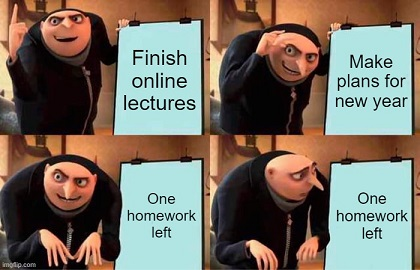

## Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a SHORT description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

## Dataset Description
The dataset I've choose to use is the ["Twitter Financial News Topic"](https://huggingface.co/datasets/zeroshot/twitter-financial-news-topic) on Hugging Face.

This dataset is designed for **topic classification tasks**, particularly in the domain of **financial news** as conveyed through Twitter.
It offers a wealth of information for evaluating and classifying financial news and trends since it comprises English-language tweets on a range of financial subjects. A variety of financial subjects, including "Analyst Update," "Fed | Central Banks," "Company | Product News," and so on (there are **20 classes**) are labelled for each tweet in the dataset. Because of this, the dataset is especially well-suited for training models that will automatically classify financial news according to their content.

The dataset is useful for anyone who want to build models for automatic news categorisation in the financial industry, analyse financial patterns, or comprehend market attitudes. The dataset also highlights the particular traits and difficulties of social media writing, such as informal language, hashtags, and abbreviations, because it is derived from Twitter.

There are 2 splits:
- **Train**	with 16,990 examples
- **Validation**	with 4,118 examples.

I observed that there is an imbalance in the dataset, with a considerably higher number of samples in some classes than in others. I decided to balance the classes with suitable weights since I thought that an imbalance might affect the model's performance and possibly cause it to forecast the majority class more frequently.

Furthermore, the majority of texts have a length of between 50 and 150 characters, with a distribution that peaks in the centre. This suggests that tweets, which frequently have a character limit, tend to be succinct and targeted. The tokenizer's `max_length` was chosen with consideration to this analysis.


### Bibliography:
- Already linked paper
- [LORA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS](https://arxiv.org/pdf/2106.09685.pdf) Hu et Al.
- [Youtube Video 1](https://www.youtube.com/watch?v=Us5ZFp16PaU&ab_channel=SamWitteveen)
- [Youtube Video 2](https://www.youtube.com/watch?v=dA-NhCtrrVE&ab_channel=ChrisAlexiuk)
- [Dataset](https://huggingface.co/datasets/zeroshot/twitter-financial-news-topic)
- [Model](https://huggingface.co/yiyanghkust/finbert-tone)

In [ ]:
# TODO: Insert all code here.
#Loading of all libraries used and of the dataset from Hugging Face
!pip install datasets
from datasets import load_dataset
from typing import Tuple, Dict, List, Union
from tensorflow.keras.callbacks import EarlyStopping
from transformers import TFBertModel, BertTokenizer
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import re
from tensorflow.keras.layers import Dense, Dropout
import os
import pandas as pd
import seaborn as sns
dataset = load_dataset("zeroshot/twitter-financial-news-topic")
import warnings
warnings.filterwarnings("ignore")
tf.config.run_functions_eagerly(True)
import gc
tf.get_logger().setLevel('ERROR')
!pip install --upgrade --no-cache-dir gdown

In [ ]:
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]

Number of training samples: 16990
Number of validation samples: 4117
Average text length: 136


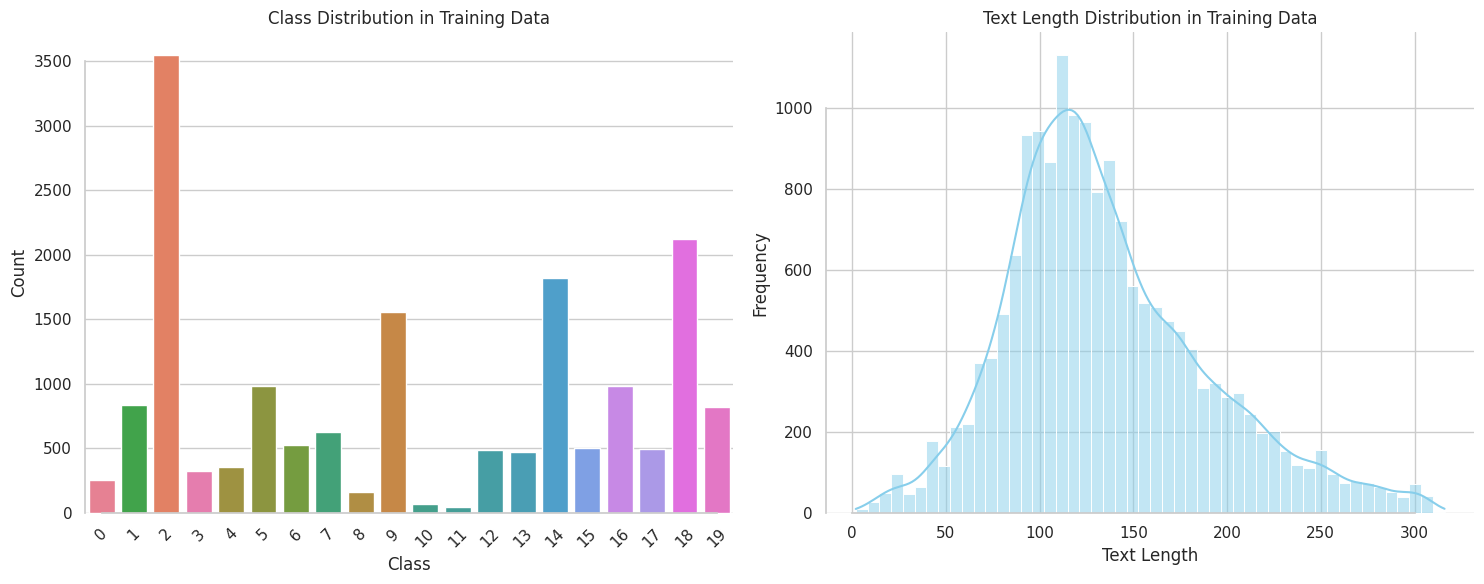

In [ ]:
# Convert to Pandas DataFrame for class distribution analysis
train_df = pd.DataFrame(train_dataset)
validation_df = pd.DataFrame(validation_dataset)

print("Number of training samples:", len(train_df))
print("Number of validation samples:", len(validation_df))

# average text length
train_df["text_length"] = train_df["text"].apply(len)
avg_text_length = train_df["text_length"].mean()
print("Average text length:", round(avg_text_length))

# subplots for class distribution and text length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

unique_labels = train_df['label'].unique()
# Generate a list of colors for each unique label
colors = sns.color_palette('husl', len(unique_labels))
# Create a dictionary to map each unique label to a color
palette = dict(zip(unique_labels, colors))
# Plot the class distribution using the custom palette and set `hue`
sns.countplot(x="label", data=train_df, hue="label", palette=palette, ax=axes[0], dodge=False, legend=False)
axes[0].set_title("Class Distribution in Training Data")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Set the Seaborn theme
sns.set_theme(style="whitegrid")
# Create the histogram with KDE and a chosen color palette
sns.histplot(train_df["text_length"], bins=50, kde=True, color="skyblue", ax=axes[1])
# Despine to remove the top and right spines
sns.despine(trim=True)
# Set titles and labels
axes[1].set_title("Text Length Distribution in Training Data")
axes[1].set_xlabel("Text Length")
axes[1].set_ylabel("Frequency")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### Preprocessing Steps:

1. **URL Replacement**: I used the special token `[URL]` to delete URLs that were present in the text. By eliminating the unpredictability brought about by unique URLs—which are unlikely to be helpful for topic classification—this step aids in the normalisation of the text data.

2. **Batch Processing**: The `preprocess` function is applied to the train and validation datasets in batches for efficiency. Batch processing speeds up the execution compared to processing each example individually.

### Tokenization:

For tokenization, we use the `BertTokenizer` from the 'yiyanghkust/finbert-tone' model. This tokenizer is specially trained for financial text and is expected to handle the domain-specific language effectively.

### Why 'yiyanghkust/finbert-tone' Tokenizer?

The choice of using the 'yiyanghkust/finbert-tone' tokenizer is motivated by the nature of our dataset:

- **Domain-Specific Vocabulary**: A tokenizer trained on related text is most effective in capturing the specific terminologies and expressions used in the financial news domain.

- **Consistency with Pretrained Models**: Using the same tokenizer is crucial for consistency if we wish to classify using the 'finbert-tone' pretrained model. Tokens generated by the tokenizer have to be identical to the tokens used to train the model.

### Dataset Preparation:

After preprocessing and tokenization, I prepared the TensorFlow datasets:

1. **Tokenization**: Tokenized the texts using the chosen tokenizer with padding and truncation to ensure a uniform length of 128 tokens.

2. **Conversion to Tensors**: Tokenized inputs are transformed into TensorFlow tensors so that neural network models can be fed into them.

3. **Dataset Object Creation**: Using the tokenized inputs and labels, we build TensorFlow `Dataset` objects. TensorFlow models may be trained effectively and conveniently with this format.

4. **Batching and Prefetching**: To increase training speed, we employ `prefetch` in conjunction with batched datasets of size 16. While the model is training, prefetching enables the data pipeline to fetch batches asynchronously.


These procedures guarantee that the dataset is clean, tokenized in accordance with domain-specific specifications, and prepared for effective deep learning model training.

In [ ]:
# initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

def preprocess(examples):
    def clean_text(text):
        # I replace URLs with a special token
        text = re.sub(r'http\S+', '[URL]', text)
        return text

    examples["text"] = [clean_text(text) for text in examples["text"]]
    return examples

# apply now the preprocessing to train and validation datasets
dataset["train"] = dataset["train"].map(preprocess, batched=True)
dataset["validation"] = dataset["validation"].map(preprocess, batched=True)

def prepare_dataset(dataset):
    tokenized_inputs = tokenizer(dataset["text"], padding=True, truncation=True, max_length=128, return_tensors="tf")
    labels = tf.convert_to_tensor(dataset["label"])
    return tf.data.Dataset.from_tensor_slices(({"input_ids": tokenized_inputs["input_ids"],
                                                "attention_mask": tokenized_inputs["attention_mask"]},
                                               labels))

# prepare train and validation datasets
train_dataset = prepare_dataset(dataset['train'])
validation_dataset = prepare_dataset(dataset['validation'])

train_dataset = train_dataset.shuffle(10000).batch(16).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## Extracting Labels and Computing Class Weights

In this section of the code, the extraction of labels is performed from the training dataset and subsequently compute class weights for imbalanced class distribution.



In [ ]:
# Extract labels from the dataset
labels = []
for _, label in train_dataset.unbatch().take(-1):
    labels.append(label.numpy())
labels = np.array(labels)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
#let's have a look
for example in train_dataset.take(1):  # Only take 1 batch for inspection
    input_ids, attention_mask, labels = example[0]["input_ids"], example[0]["attention_mask"], example[1]

    # convert the input_ids and attention_mask back to text for readability
    for i in range(input_ids.shape[0]):
        print("Text:", tokenizer.decode(input_ids[i], skip_special_tokens=True))
        print("Attention mask:", attention_mask[i])
        print("Label:", labels[i])
        print("\n")
        break

Text: the new home company schedules second quarter 2022 earnings conference call [ url ] [ url ]
Attention mask: tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(128,), dtype=int32)
Label: tf.Tensor(5, shape=(), dtype=int32)




### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

In the following sections, you can find the implementation of `LoRA`(Low-Rank Adaptation) into this pretrained [model](https://huggingface.co/yiyanghkust/finbert-tone). The model is taken from HugginFace, is a BERT model pre-trained on financial communication text and  is specially trained for financial text and is expected to handle the domain-specific language effectively.


The idea of LoRA is to keep the weights of the already pre-trained model freezed and learn a matrix `ΔW = A×B` where the rank of the two matrices is
`r << (k,d)`, where kxd is the dimention of the weights matrix.
This is beneficial since it allow us to learn a very small number of parameters in confront to the dimention of W.

I found a little bit tricky and challenging to adapt the model chosen from Hugging Face, primarily due to their models high level of encapsulation and abstraction.
Since was not possible to replace directly the layer with a custom one, the approach I took involved manipulating the weights of the existing layers indirectly. This is done by applying low-rank updates to the weights during the forward pass of the model.

Of course the original weights of the model are freezed, for each forward pass they are temporarly adjusted with the low rank matrices, which are learned during training.

The initialization of the matrix A and B it's crutial, initializing A with a Normal distribution and B with zeros, we make sure that at the beginning the model we introduce no changes and the model starts from a point that is close to the original one, chosen by the pretrained model.

When we will run the model, it will be crucial to select a small value of learning rate to make sure that our update won't make the solution too far to the already decent position in the landscape of the loss.



In [ ]:
finbert_model = TFBertModel.from_pretrained('yiyanghkust/finbert-tone', trainable=False)
#to ensure we can access the weights
for i, weight in enumerate(finbert_model.weights):
    print(f"Weight {i}: Name - {weight.name}, Shape - {weight.shape}")

Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Weight 0: Name - tf_bert_model_8/bert/embeddings/word_embeddings/weight:0, Shape - (30873, 768)
Weight 1: Name - tf_bert_model_8/bert/embeddings/token_type_embeddings/embeddings:0, Shape - (2, 768)
Weight 2: Name - tf_bert_model_8/bert/embeddings/position_embeddings/embeddings:0, Shape - (512, 768)
Weight 3: Name - tf_bert_model_8/bert/embeddings/LayerNorm/gamma:0, Shape - (768,)
Weight 4: Name - tf_bert_model_8/bert/embeddings/LayerNorm/beta:0, Shape - (768,)
Weight 5: Name - tf_bert_model_8/bert/encoder/layer_._0/attention/self/query/kernel:0, Shape - (768, 768)
Weight 6: Name - tf_bert_model_8/bert/encoder/layer_._0/attention/self/query/bias:0, Shape - (768,)
Weight 7: Name - tf_bert_model_8/bert/encoder/layer_._0/attention/self/key/kernel:0, Shape - (768, 768)
Weight 8: Name - tf_bert_model_8/bert/encoder/layer_._0/attention/self/key/bias:0, Shape - (768,)
Weight 9: Name - tf_bert_model_8/bert/encoder/layer_._0/attention/self/value/kernel:0, Shape - (768, 768)
Weight 10: Name - tf_

In [ ]:
#dictionary of the matrices A and B that will be created for each layer of the model
lora_matrices = {}
r = 8  # rank for LoRA matrices
lora_alpha = 16  # scaling factor, is emphirical and is also talked in the paper in section 4.1
                 #they said that should at least start with the value of r, I choose 16
                 #talked also here https://datascience.stackexchange.com/questions/123229/understanding-alpha-parameter-tuning-in-lora-paper

for weight in finbert_model.weights:
    # get the shape of the weight tensor
    shape = weight.shape
    if len(shape) == 2:
        # initialize A with random normal values, as stated before
        A = tf.Variable(tf.random.normal([shape[0], r]), trainable=True, name=weight.name + '_lora_A')
        # initialize B with zeros, to preserve the structure
        B = tf.Variable(tf.zeros([r, shape[1]]), trainable=True, name=weight.name + '_lora_B')
        lora_matrices[weight.name] = (A, B)
    #it raised an error for some weights layer,so I need to took into account this case too
    elif len(shape) == 1:
        # handle 1-dimensional weight tensors differently
        A = tf.Variable(tf.random.normal([shape[0], r]), trainable=True, name=weight.name + '_lora_A')
        B = None  # set B to None for 1-dimensional tensors
        lora_matrices[weight.name] = (A, B)


class BertWithLoRA(tf.keras.Model):
    '''
    This class inherits from tf.keras.Model and integrates the LoRA matrices into the pre-trained BERT model.
    During the forward pass the LoRA updates are applied to the weights of the original BERT model.
    The original weights has to be stored and then restored after the call to ensure that the original structure is saved.
    Consider that in this implementation the rank r parameter is not passed.
    Parameters:
    bert_model: the chosen model.
    lora_matrices: dictionary with the matrices for each weight layer in the model.
    lora_alpha: scaling factor
    num_classes: The number of output classes for classification.
    '''
    def __init__(self, bert_model, lora_matrices, lora_alpha, num_classes=20, **kwargs):
        super(BertWithLoRA, self).__init__(**kwargs)
        self.bert = bert_model
        self.lora_matrices = lora_matrices
        self.lora_alpha = lora_alpha
        self.classifier = tf.keras.layers.Dense(num_classes)  # Classification layer

    def call(self, inputs):
        # Apply LoRA updates
        original_weights = {}
        for weight in self.bert.weights:
            if weight.name in self.lora_matrices:
                original_weights[weight.name] = tf.identity(weight)
                A, B = self.lora_matrices[weight.name]
                lora_update = A @ B * self.lora_alpha
                weight.assign_add(lora_update)

        # Forward pass through BERT
        bert_output = self.bert(inputs)[1]

        # Restore original weights
        for weight in self.bert.weights:
            if weight.name in original_weights:
                weight.assign(original_weights[weight.name])

        # Pass through classifier
        return self.classifier(bert_output)

In [ ]:
finbert_model = TFBertModel.from_pretrained('yiyanghkust/finbert-tone', trainable=False)
LoRA_weight_model = BertWithLoRA(finbert_model, lora_matrices, lora_alpha)

# define optimizer and loss function
lora_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# metrics for monitoring training and validation accuracy
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# optimizing data loading
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

#by manually defining the training step, I could insert the LoRA weight updates
#and ensure they are applied correctly at each step and updated
@tf.function
def train_step(x_batch_train, y_batch_train):
    with tf.GradientTape() as tape:
        logits = LoRA_weight_model(x_batch_train, training=True)
        loss_value = loss_fn(y_batch_train, logits)
    grads = tape.gradient(loss_value, LoRA_weight_model.trainable_variables)
    lora_optimizer.apply_gradients(zip(grads, LoRA_weight_model.trainable_variables))
    train_acc_metric.update_state(y_batch_train, logits)
    return loss_value


epochs = 15
for epoch in range(epochs):
    print(f"Start of Epoch {epoch + 1}")

    # training phase
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        if step % 300 == 0:
            print(f"Training loss at step {step}: {loss_value.numpy():.4f}")
            print(f"Training accuracy so far: {train_acc_metric.result().numpy():.4f}")

    # validation phase
    for x_batch_val, y_batch_val in validation_dataset:
        val_logits = LoRA_weight_model(x_batch_val, training=False)
        val_acc_metric.update_state(y_batch_val, val_logits)

    print(f"Validation accuracy at epoch {epoch + 1}: {val_acc_metric.result().numpy():.4f}")

    # reset metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()


    gc.collect()
    tf.keras.backend.clear_session()


Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Start of Epoch 1
Training loss at step 0: 3.3683
Training accuracy so far: 0.1875
Training loss at step 300: 2.7490
Training accuracy so far: 0.1030
Training loss at step 600: 2.7226
Training accuracy so far: 0.1331
Training loss at step 900: 2.6623
Training accuracy so far: 0.1546
Validation accuracy at epoch 1: 0.2565
Start of Epoch 2
Training loss at step 0: 2.7918
Training accuracy so far: 0.1875
Training loss at step 300: 2.3002
Training accuracy so far: 0.2897
Training loss at step 600: 2.3174
Training accuracy so far: 0.2663
Training loss at step 900: 2.6571
Training accuracy so far: 0.2689
Validation accuracy at epoch 2: 0.3318
Start of Epoch 3
Training loss at step 0: 2.5412
Training accuracy so far: 0.1875
Training loss at step 300: 2.1886
Training accuracy so far: 0.3360
Training loss at step 600: 2.3312
Training accuracy so far: 0.3182
Training loss at step 900: 2.4812
Training accuracy so far: 0.3211
Validation accuracy at epoch 3: 0.3668
Start of Epoch 4
Training loss at 

Unfortunately I was not able to train longer, the process as constructed is slower than the classic fit on Keras, so I was able to train only on the first 15 epochs, but the results seems promising.
Also is important to take into account that NO weights of the pre-trained model were unfreezed, so as it is common, choose to unfreeze only a small percentage of the already pre-trained ones could potentially increase the accuracy!!

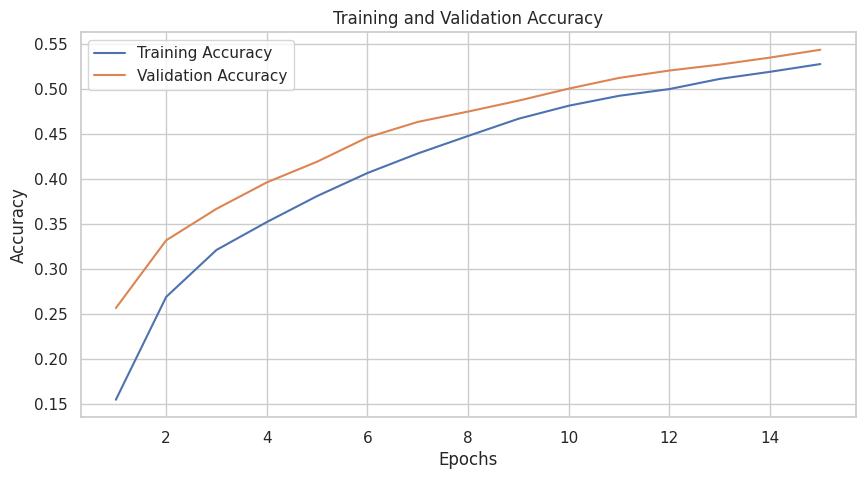

In [ ]:
# Manually extracted accuracies(I know it's bad, but was to late when I noticed that)
train_accuracies = [0.1546, 0.2689, 0.3211, 0.3521, 0.3810, 0.4066, 0.4283, 0.4478, 0.4669, 0.4814, 0.4924, 0.4999, 0.5112, 0.5191, 0.5277]
val_accuracies = [0.2565, 0.3318, 0.3668, 0.3962, 0.4192, 0.4462, 0.4634, 0.4749, 0.4870, 0.5004, 0.5123, 0.5205, 0.5271, 0.5349, 0.5436]

epochs = range(1, 16)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
LoRA_weight_model.summary()

Model: "bert_with_lo_ra"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_1 (TFBertMod  multiple                  109751808 
 el)                                                             
                                                                 
 dense (Dense)               multiple                  15380     
                                                                 
Total params: 112353004 (428.59 MB)
Trainable params: 2601196 (9.92 MB)
Non-trainable params: 109751808 (418.67 MB)
_________________________________________________________________


As shown I was able to add correctly the low rank matrices to the weights of the already pretrained model, the structure of the model it remain the same and also the percentage of trainable parameters is really small compared to the size of the model!!

# 'Alternative' LoRA

Now a secondary approach is taken.
Due to the nature of the architecture of the model in HugginFace I tried to sequencially add some layer of LoRA matrices.

The layers added, called `LoRA` are a custom layer derived from tf.keras.layers.Layer. The name LoRA is probably used not properly and the implementation deviate for sure from the conventional one, but it remind that the layer's weights are influenced by the concept of LoRA. Each LoRALayer incorporates matrices A and B with dimensions that maintain a low rank r, significantly smaller than the original weight matrix's dimensions (k, d).

Again, this is beneficial since it allow us to learn a very small number of parameters in confront to the dimention of W.

Same discussion about the inizialization and learning rate are valid.

The model that is allowed to unfreeze a percentage of layers(later on in the notebook) achieved an impressive accuracy, I probably think that this is obtained because of this can be particularly beneficial in handling sparse information, as it focuses the model's learning capacity on the most impactful parameters due to the structure of the matrices A and B.


In [ ]:
# TODO: Your code here.

In [ ]:
class LoRA(tf.keras.layers.Layer):
    '''
    LoRA is a custom layer that is derived from tf.keras.layers.Layer., it doesn't respect the pure implementation of LoRA.
    Its purpose is to include LoRA(Low Rank Adaptation) sequentially to the already pretrained model.
    We learn the low rank matrices A(input x r dimention) and B(r x units dimentions),
    the value units is passed.
    Parameters:
    units: The dimensionality of the output space.
    rank: The rank parameter for LoRA, controlling the number of parameters.
          The value of 4 is choosen accordingly to the paper.
    dropout_rate: The rate of dropout applied to the LoRA update during training.
    '''
    def __init__(self, units, rank=4, dropout_rate=0.1, **kwargs):
        super(LoRA, self).__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.b = self.add_weight(name='b',
                                 shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        self.A = self.add_weight(name='A',
                                  shape=(input_shape[-1], self.rank),
                                  initializer='random_normal',
                                  trainable=True)
        self.B = self.add_weight(name='B',
                                  shape=(self.rank, self.units),
                                  initializer='zeros',
                                  trainable=True)

    def call(self, inputs, training=False):
        lora_update = tf.matmul(inputs, self.A)
        if training:
            lora_update = Dropout(self.dropout_rate)(lora_update)
        lora_update = tf.matmul(lora_update, self.B)
        return lora_update + self.b


This is a custom model named `FinBERTLoRAModel_classic` that inherits from tf.keras.Model. and implement the LoRA sequentially as stated before.

It incorporates the FinBERT pre-trained BERT model with an added LoRA layer and a classifier.
The added part `_classic` is because in this implementation all the weights of the pretrained model are freezed, updating only a very small percentage of parameters, but achieving not a high accuracy(I stopped after 30 epochs).

In [ ]:
class FinBERTLoRAModel_classic(tf.keras.Model):
    '''
    The weights of the pre-trained BERT model are frozen.

    Parameters:
    num_classes: The number of output classes for classification.
    rank: The rank parameter for LoRA.

    Components:
    A pre-trained BERT model (TFBertModel) from 'yiyanghkust/finbert-tone' with trainable set to False.
    A dropout layer with a dropout rate of 0.1.
    A dense layer for final classification with num_classes output units.
    '''
    def __init__(self, num_classes, rank=4, **kwargs):
        super(FinBERTLoRAModel_classic, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('yiyanghkust/finbert-tone', trainable=False)

        self.lora_layer = LoRA(self.bert.config.hidden_size, rank=rank)

        self.dropout = Dropout(0.1)
        self.classifier = Dense(num_classes)

    def call(self, inputs, training=False):
        '''
        method defines the forward pass of the model. It takes input IDs and attention mask as inputs,
        passes them through the frozen BERT model, extracts the pooled output, applies the LoRA layer,
        and finally passes it through dropout and the classifier for classification
        '''
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output

        # Apply the LoRA layer
        lora_output = self.lora_layer(pooled_output, training=training)

        lora_output = self.dropout(lora_output, training=training)
        final_output = self.classifier(lora_output)
        return final_output


In [ ]:
# instantiation of the model
num_classes = 20
lora_rank = 16

model_classic = FinBERTLoRAModel_classic(num_classes=num_classes, rank=lora_rank)

#a low learning rate is choosen since in fine tuning task is important to not overshoot
#from the 'considered' smooth area where the pretrained model arrived
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_classic.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# define an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
# fit the model
history_classic = model_classic.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)


tf_model.h5:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/30
531/531 [==============================] - 212s 361ms/step - loss: 2.9816 - accuracy: 0.0811 - val_loss: 2.9633 - val_accuracy: 0.0908
Epoch 2/30
531/531 [==============================] - 189s 356ms/step - loss: 2.9191 - accuracy: 0.0733 - val_loss: 2.8906 - val_accuracy: 0.0853
Epoch 3/30
531/531 [==============================] - 189s 356ms/step - loss: 2.8293 - accuracy: 0.1011 - val_loss: 2.8137 - val_accuracy: 0.1095
Epoch 4/30
531/531 [==============================] - 189s 356ms/step - loss: 2.7447 - accuracy: 0.1175 - val_loss: 2.7403 - val_accuracy: 0.1370
Epoch 5/30
531/531 [==============================] - 189s 356ms/step - loss: 2.6727 - accuracy: 0.1411 - val_loss: 2.6668 - val_accuracy: 0.1732
Epoch 6/30
531/531 [==============================] - 195s 367ms/step - loss: 2.6046 - accuracy: 0.1725 - val_loss: 2.5946 - val_accuracy: 0.2101
Epoch 7/30
531/531 [==============================] - 189s 355ms/step - loss: 2.5420 - accuracy: 0.1993 - val_loss: 2.5297 -

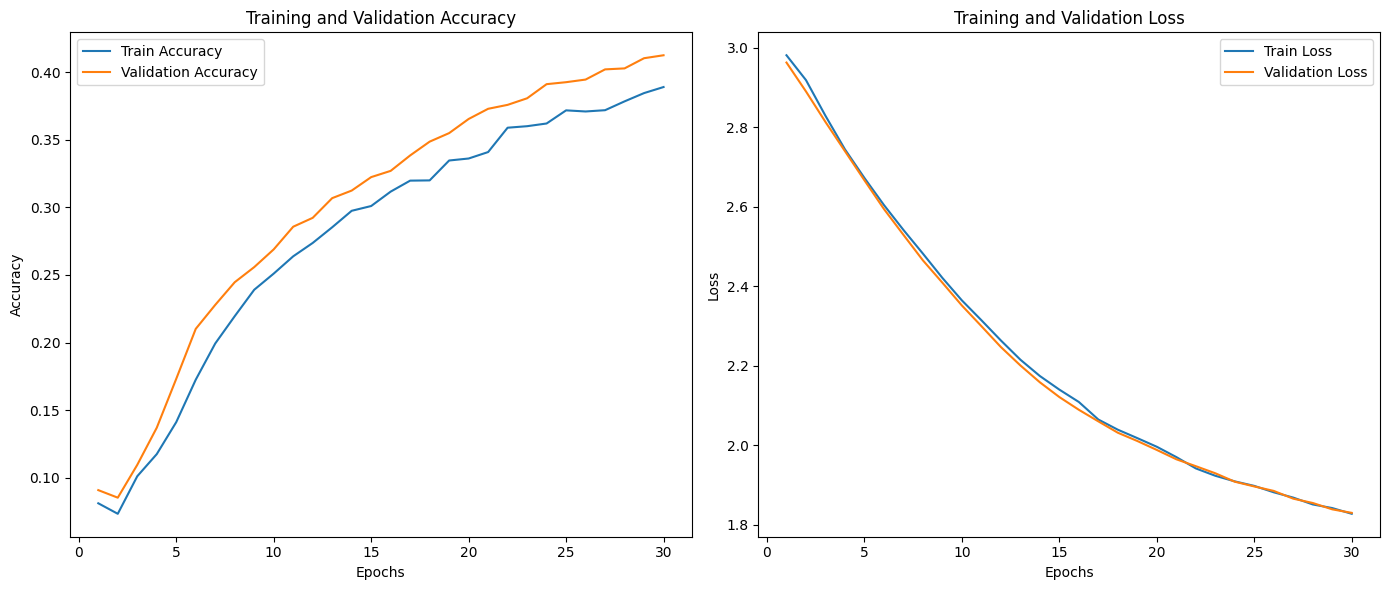

In [ ]:
# we extract accuracy and loss values from the history
train_accuracy = history_classic.history['accuracy']
val_accuracy = history_classic.history['val_accuracy']
train_loss = history_classic.history['loss']
val_loss = history_classic.history['val_loss']

# create a list of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)

# create a Seaborn plot with two subplots (one for accuracy and one for loss)
plt.figure(figsize=(14, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=train_accuracy, label='Train Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')

# Subplot for loss
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=train_loss, label='Train Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')

plt.tight_layout()

plt.show()

In [ ]:
model_classic.summary()

Model: "fin_bert_lo_ra_model_classic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model (TFBertModel  multiple                  109751808 
 )                                                               
                                                                 
 lo_ra (LoRA)                multiple                  25344     
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 dense (Dense)               multiple                  15380     
                                                                 
Total params: 109792532 (418.83 MB)
Trainable params: 40724 (159.08 KB)
Non-trainable params: 109751808 (418.67 MB)
_________________________________________________________________


As shown the percentange of updated parameters are very small, but accuracy poor. In the next cell there is the implementation of the `FinBERTLoRAModel`, this time I allow the update of a part of the pretrained weights. The hyperparameter `unfreeze_layers`, controls the number of last layers to unfreez and update. Modifying this parameter will allow us to achieve a better accuracy.

With this modification(that is used also in this [paper](https://arxiv.org/pdf/2106.09685.pdf)) the accuracy is boosted, arriving to a value of 0.88.

In [ ]:
class FinBERTLoRAModel(tf.keras.Model):
    '''
    This is an updated version of the FinBERTLoRAModel, named FinBERTLoRAModel,
    where a percentage of the weights of the pre-trained BERT model are frozen.
    Modifying the parameter _unfreeze_layers_ will change this percentage.

    Parameters:
    num_classes: The number of output classes for classification.
    rank: The rank parameter for LoRA.
    unfreeze_layers: The number of layers of the pretrained model to unfreeze.

    Components:
    A pre-trained BERT model (TFBertModel) from 'yiyanghkust/finbert-tone' with trainable set to False.
    A dropout layer with a dropout rate of 0.1.
    A dense layer for final classification with num_classes output units.
    '''
    def __init__(self, num_classes, rank=4, unfreeze_layers=5, **kwargs):
        super(FinBERTLoRAModel, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('yiyanghkust/finbert-tone')

        # set BERT layers to non-trainable
        self.set_bert_layers_trainable(False)

        # unfreeze the last 'unfreeze_layers' of BERT's encoder layers
        self.set_bert_layers_trainable(True, last_n_layers=unfreeze_layers)

        # initialize one LoRA layer
        self.lora_layer = LoRA(self.bert.config.hidden_size, rank=rank)

        self.dropout = Dropout(0.1)
        self.classifier = Dense(num_classes)

    def set_bert_layers_trainable(self, trainable, last_n_layers=None):
        if last_n_layers is not None:
            # unfreeze only the last 'last_n_layers' layers
            for layer in self.bert.bert.encoder.layer[-last_n_layers:]:
                layer.trainable = trainable
        else:
            for layer in self.bert.bert.encoder.layer:
                layer.trainable = trainable

    def call(self, inputs, training=False):
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output

        # apply the LoRA layer
        lora_output = self.lora_layer(pooled_output, training=training)

        lora_output = self.dropout(lora_output, training=training)
        final_output = self.classifier(lora_output)
        return final_output


In [ ]:
num_classes = 20
lora_rank = 16
# we have to set the new parameter
unfreeze_layers_true = 3
# instantiate and compile the model as before
model = FinBERTLoRAModel(num_classes=num_classes, rank=lora_rank, unfreeze_layers=unfreeze_layers_true)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  # same motivation as before
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
# Fit the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)


tf_model.h5:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/30
531/531 [==============================] - 410s 717ms/step - loss: 2.6365 - accuracy: 0.1467 - val_loss: 2.2433 - val_accuracy: 0.2346
Epoch 2/30
531/531 [==============================] - 381s 718ms/step - loss: 2.0023 - accuracy: 0.2222 - val_loss: 2.0082 - val_accuracy: 0.2349
Epoch 3/30
531/531 [==============================] - 383s 722ms/step - loss: 1.6903 - accuracy: 0.2885 - val_loss: 1.8324 - val_accuracy: 0.3354
Epoch 4/30
531/531 [==============================] - 383s 722ms/step - loss: 1.3554 - accuracy: 0.4252 - val_loss: 1.4901 - val_accuracy: 0.4984
Epoch 5/30
531/531 [==============================] - 383s 722ms/step - loss: 1.0656 - accuracy: 0.5478 - val_loss: 1.3236 - val_accuracy: 0.5941
Epoch 6/30
531/531 [==============================] - 382s 720ms/step - loss: 0.8330 - accuracy: 0.6602 - val_loss: 1.1624 - val_accuracy: 0.6777
Epoch 7/30
531/531 [==============================] - 383s 721ms/step - loss: 0.6642 - accuracy: 0.7401 - val_loss: 0.9744 -

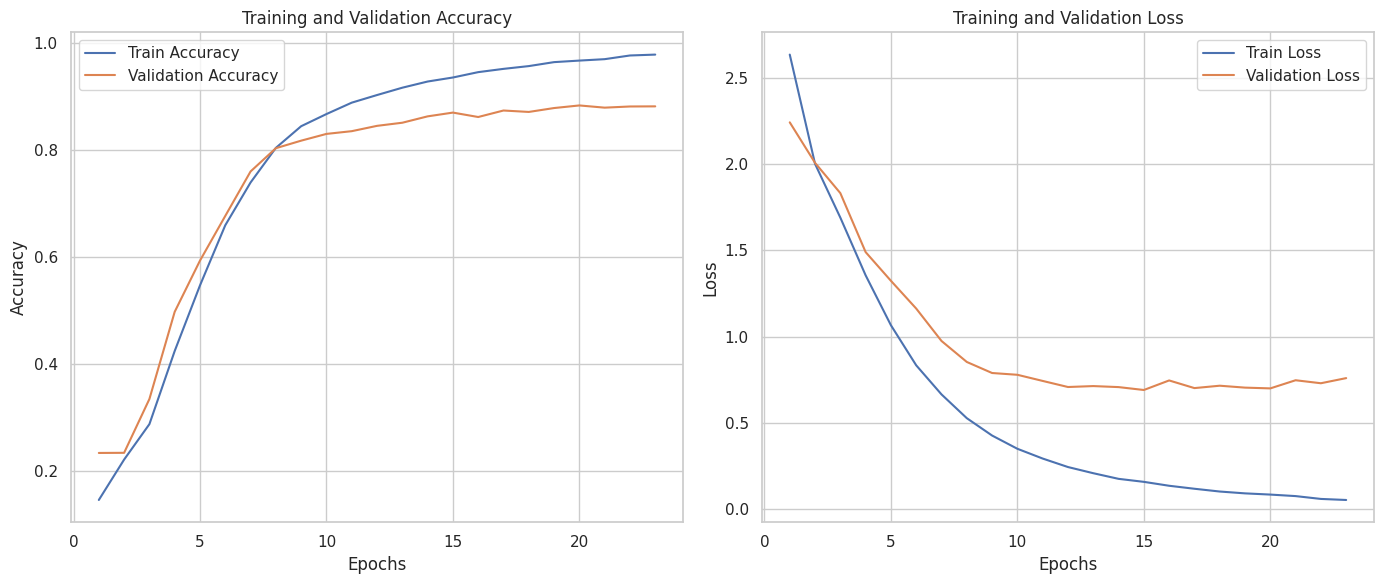

In [ ]:
# we extract accuracy and loss values from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# create a list of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)

# create a Seaborn plot with two subplots (one for accuracy and one for loss)
plt.figure(figsize=(14, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=train_accuracy, label='Train Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')

# Subplot for loss
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=train_loss, label='Train Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')

plt.tight_layout()

plt.show()

In [ ]:
model.summary()

Model: "fin_bert_lo_ra_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model (TFBertModel  multiple                  109751808 
 )                                                               
                                                                 
 lo_ra (LoRA)                multiple                  25344     
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 dense (Dense)               multiple                  15380     
                                                                 
Total params: 109792532 (418.83 MB)
Trainable params: 46001684 (175.48 MB)
Non-trainable params: 63790848 (243.34 MB)
_________________________________________________________________


With this implemenation and this choise of parameters an accuracy of 0.88 is achieved, using approximately 40% of the total parameters and 177.66MB, that can be relatevely few.

In [ ]:
#same print of the correctness of the procedure
print("Example data:", dataset['validation'][0])

example = dataset['validation'][0]['text']
tokenized_example = tokenizer(example, padding=True, truncation=True, max_length=128, return_tensors="tf")
print("Tokenized example:", tokenized_example)

# prepare a small part of the dataset for testing
small_val_dataset = prepare_dataset(dataset['validation'][:10])

for inputs, labels in small_val_dataset.take(1):
    print("Inputs:", inputs)
    print("Input shapes:", {k: v.shape for k, v in inputs.items()})
    print("Labels:", labels)
    print("Label shape:", labels.shape)

# running the model on a single batch
for inputs, labels in small_val_dataset.batch(1).take(1):
    try:
        predictions = model(inputs)
        print("Predictions:", predictions)
    except Exception as e:
        print("Error during model prediction:", e)

# apply softmax to convert logits to probabilities
probabilities = tf.nn.softmax(predictions, axis=1)
print("Probabilities:", probabilities)
# get the class with the highest probability
chosen_class = tf.argmax(probabilities, axis=1)
print("Chosen class:", chosen_class.numpy())

Example data: {'text': 'Analyst call of the day for @CNBCPro subscribers: Goldman Sachs reiterates Exxon as buy and says it’s bullish heading into earnings next week.  Subscribe to see the analyst calls of the day curated by CNBC Pro.  [URL]', 'label': 0}
Tokenized example: {'input_ids': <tf.Tensor: shape=(1, 53), dtype=int32, numpy=
array([[    3,   508,   347,     7,     6,  1037,    14, 17039,  6527,
         8225,  3987,  2826,  3108,  2485,  4549,  3247,    63, 16003,
           18,   500,     8,  8276,    41, 30748,    58,  5945,  4555,
          119,   149,   165,  1952,    48,  9356,     9,   153,     6,
          508,  2602,     7,     6,  1037, 25262,  3095,    24,  6527,
         8225,  1547,    48,  4249,  8270,   604,  7115,     4]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 53), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

## INFERENCE
Now it's time to use the fine-tuned model to real application.
I searched for some article online, mainly on **Cncb** and **Reuters** to check if the model is functioning correctly.

In [ ]:
#actual label of the dataset
topics = {
    "LABEL_0": "Analyst Update",
    "LABEL_1": "Fed | Central Banks",
    "LABEL_2": "Company | Product News",
    "LABEL_3": "Treasuries | Corporate Debt",
    "LABEL_4": "Dividend",
    "LABEL_5": "Earnings",
    "LABEL_6": "Energy | Oil",
    "LABEL_7": "Financials",
    "LABEL_8": "Currencies",
    "LABEL_9": "General News | Opinion",
    "LABEL_10": "Gold | Metals | Materials",
    "LABEL_11": "IPO",
    "LABEL_12": "Legal | Regulation",
    "LABEL_13": "M&A | Investments",
    "LABEL_14": "Macro",
    "LABEL_15": "Markets",
    "LABEL_16": "Politics",
    "LABEL_17": "Personnel Change",
    "LABEL_18": "Stock Commentary",
    "LABEL_19": "Stock Movement",
}

In [ ]:
examples = [
    'Sterling surges on better-than-expected PMI, consumer credit https://www.reuters.com/markets/currencies/sterling-surges-better-than-expected-pmi-consumer-credit-2024-01-04/#:~:text=LONDON%2C%20Jan%204%20(Reuters),resilient%20than%20feared%20economic%20picture.',
    'Stocks making the biggest moves midday: Xerox, SoFi, Charles Schwab and more https://www.cnbc.com/2024/01/03/stocks-making-the-biggest-moves-midday-xrx-sofi-schw.html',
    'Stocks making the biggest moves midday: Moderna, Apple, GoodRx and more https://www.cnbc.com/2024/01/02/stocks-making-the-biggest-moves-midday-mrna-aapl-gdrx-coin.html',
    'Deadly Iran blasts and Red Sea attacks deepen fears of a wider Middle East war https://www.cnbc.com/2024/01/04/iran-blasts-and-red-sea-attacks-stoke-fears-of-a-wider-middle-east-war.html',
    'Deutsche Bank names the stock that’ll be the ‘last man standing’ in autonomous driving https://www.cnbc.com/2024/01/04/deutsche-bank-names-stock-seen-as-last-man-standing-in-driverless-tech.html',
    'USD drags down gold and silver prices https://www.kitco.com/news/article/2024-01-03/gold-silver-smacked-bounce-greenback-profit-taking',
    'Trump seeks to hold special counsel in contempt for violating pause in election case https://www.reuters.com/legal/trump-seeks-hold-special-counsel-contempt-violating-pause-election-case-2024-01-04/',
    'Suraj Estate shares debut on Dalal Street at ₹340 apiece https://www.cnbctv18.com/market/suraj-estate-ipo-listing-date-today-debut-bse-nse-issue-price-18642491.htm'
]

for example_text in examples:
    # Tokenize the text
    tokenized_example = tokenizer.encode_plus(
        example_text,
        max_length=128,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

    # Make a prediction
    with tf.device('/cpu:0'):  # Use CPU for inference
        prediction = model.predict({
            'input_ids': tokenized_example['input_ids'],
            'attention_mask': tokenized_example['attention_mask']
        })

    # Interpret the result
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = topics[f"LABEL_{predicted_class_index}"]
    print(f"Example: '{example_text}'")
    print(f"Predicted Topic: {predicted_class_label}\n")


1/1 [==============================] - 10s 10s/step
Example: 'Sterling surges on better-than-expected PMI, consumer credit https://www.reuters.com/markets/currencies/sterling-surges-better-than-expected-pmi-consumer-credit-2024-01-04/#:~:text=LONDON%2C%20Jan%204%20(Reuters),resilient%20than%20feared%20economic%20picture.'
Predicted Topic: Currencies

1/1 [==============================] - 1s 769ms/step
Example: 'Stocks making the biggest moves midday: Xerox, SoFi, Charles Schwab and more https://www.cnbc.com/2024/01/03/stocks-making-the-biggest-moves-midday-xrx-sofi-schw.html'
Predicted Topic: Stock Movement

1/1 [==============================] - 1s 681ms/step
Example: 'Stocks making the biggest moves midday: Moderna, Apple, GoodRx and more https://www.cnbc.com/2024/01/02/stocks-making-the-biggest-moves-midday-mrna-aapl-gdrx-coin.html'
Predicted Topic: Stock Movement

1/1 [==============================] - 1s 500ms/step
Example: 'Deadly Iran blasts and Red Sea attacks deepen fears of 

Everything seems to work perfectly!

### Exercise 2: Interpreting the results (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercise 1, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1 and 2 for a total of *15 points*.

[LIME](https://arxiv.org/abs/1602.04938) (**Local Interpretable Model-agnostic Explanations**) is a very common explainability method, which trains a small interpretable model (e.g., a linear model) around a prediction $f(x)$ to interpret the prediction. For this exercise:

1. Read carefully the original LIME paper.
2. Re-implement the LIME algorithm and test it on 1 or 2 predictions given by your neural network (from Exercise 1).
3. This must be done fully in TensorFlow (same as the previous exercise).
4. LIME requires to select how to represent the inputs (e.g., patches of the original image). Explain your choice below.
5. Analyze the results you obtain.

In [ ]:
# TODO: Implement and test LIME.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

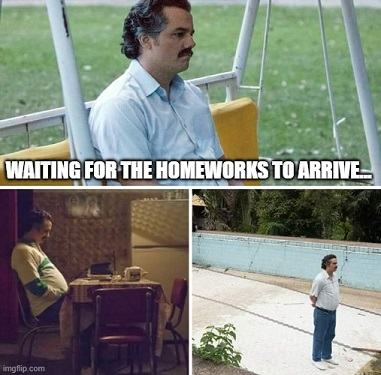